This code builds Latent Dirichlet Allocation (LDA) and NMF models from cleaned tweet data (in the sample_tweet_data tsv). I have only included the code that runs the models and plots the topic clusters, as the code that streams and cleans the tweets was written before this class started. To run, be sure to load each cell, and then run the cell down that contains the call to the lda_analysis and nmf_analysis functions. The matplotlib plots will be automatically generated. If you want to generate an interactive plotly plot, load and run the next set of cells after you have run the cells that build the models.  

In [4]:
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation 
import pickle

In [9]:
"""
Topic modeling on time series data
Sample call from commandline:
python topic_modeling.py --path ~/Documents/Git/Twitter-Mining/streaming_tweets/data/streaming_guns_rights_guncontrol_converted_tweets.tsv
"""


def nmf_analysis(data, optimize = True, n_topics = None):
    """
    Vectorize tweet data into a tfidf matrix. Run NMF on the matrix. If optimize = True, 
    grid search will report out model's performance as the number of topics change.
    http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
    """
    
    n_features = 1000 
    n_top_words = 10

    tfidf_vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2, max_features=n_features, stop_words='english')
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
    # term frequency * inverse document frequency

    tfidf = tfidf_vectorizer.fit_transform(data['filtered_text'])
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()

    # Optimize:
    if optimize == True:
        data = grid_search(tfidf, tfidf_feature_names, data, "NMF")
        return data, topics
    
    else:
        print("Building model...")
        nmf = NMF(n_components = n_topics, random_state = 0).fit(tfidf)
        nmf_transform = nmf.transform(tfidf)
        error = nmf.reconstruction_err_
        print("Frobenius norm: {}".format(error))
        topics = display_topics(nmf, tfidf_feature_names, n_top_words)
        
        nmf_keys = []
        for i in range(nmf_transform.shape[0]):
            nmf_keys.append(nmf_transform[i].argmax()) # Change to string so label types can be consistent for plotting
        
        data['labels'] = pd.Series(nmf_keys)
        tsne_data = run_tsne(nmf_transform)
        data['x'] = pd.Series(tsne_data[:, 0])
        data['y'] = pd.Series(tsne_data[:, 1])
        
        visualize_mpl(tweet_dataframe, topics, error, "NMF")
        
        return data, topics
        
def lda_analysis(data, stream_info, optimize = True, n_topics = None):
    """ 
    Vectorize tweet data and run LDA. If optimize = True, grid search will run and report perplexity 
    of the model as the number of topics changes.
    LDA can only use raw term counts for LDA because it is a probabilistic graphical model
    """

    n_features = 1000 
    n_top_words = 5

    tf_vectorizer = CountVectorizer(
        max_df = 0.95, 
        min_df = 2, 
        max_features = n_features, 
        ngram_range = (1, 3), 
        stop_words='english')
    tf = tf_vectorizer.fit_transform(data['filtered_text'])
    tf_feature_names = tf_vectorizer.get_feature_names()
    
    if optimize == True:
        # Find optimal number of components
        data = grid_search(tf, tf_feature_names, data, "LDA")
        return data, topics
        
    else:
        lda = LatentDirichletAllocation(n_components = n_topics, learning_method = 'online', random_state=0).fit(tf)
        lda_transform = lda.transform(tf)
        error = lda.perplexity(tf)
        print("Model's perplexity:", error)
        print("Model's score':" , lda.score(tf))
        topics = display_topics(lda, tf_feature_names, n_top_words, stream_info)
        
        lda_keys = []
        for i in range(lda_transform.shape[0]):
            lda_keys.append(lda_transform[i].argmax()) # Change to string so label types can be consistent for plotting
        
        data['labels'] = pd.Series(lda_keys)
        
        # Drop tweets with low probability of being in any topic, if desired
        reduced_data, reduced_index = drop_tweets(lda_transform, data)
        
        data = reduced_data.copy() 
        data.reset_index(drop = True, inplace = True)
        
        tsne_data = run_tsne(lda_transform[reduced_index]) 
        
        # One definite way to get this to work: drop after tsne is run and added to data..
        #tsne_data = run_tsne(lda_transform)
        
        data['x'] = pd.Series(tsne_data[:, 0])
        data['y'] = pd.Series(tsne_data[:, 1])
        
        # Here's the dropping with the inefficient method
        #data = data.loc[reduced_index].copy()
        
        # Show the tweets most representative of a topic
        tweet_per_topic(data, lda_transform[reduced_index])
        
        visualize_mpl(data, topics, error, "LDA")
        
        return data, topics

def tweet_per_topic(tweet_dataframe, probabilities):

    representative_tweets = {}
    index = []
    probabilities_df = pd.DataFrame(probabilities).copy()
    print(probabilities_df.index)

    for i in range(n_topics):
        #index.append(probabilities_df.loc[tweet_dataframe['labels'] == i, i].idxmax())
        index.append(probabilities_df.loc[:, i].idxmax())
        print("Most representative tweet of topic {}:\n".format(i), tweet_dataframe.loc[index[i], 'text'], "\n")
        #print("assigned to topic ", tweet_dataframe.loc[index[i], 'labels'], "\n")
        key = '{}'.format(i)
        representative_tweets[key] = tweet_dataframe.loc[index[i], 'text']
        
        # top 5 tweets
        #index_top5 = np.argsort(probabilities_df.loc[:, i])[:-6:-1]
        #print("Top 5 most representative tweets:\n", tweet_dataframe.loc[index_top5, 'text'], "\n")

    with open('representative_tweets.pickle', 'wb') as f:
        pickle.dump(representative_tweets, f)
    
    with open('rep_tweet_index.pickle', 'wb') as f:
        pickle.dump(index, f)
    
def grid_search(vectorized_data, feature_names, tweet_dataframe, method = "NMF"):
    
    """
    Creates models with iteratively increasing number of topics. If "LDA" is passed when 
    function is called, LDA will be run. NMF is the default.
    Reports model's performance and displays bar graphs with most frequent words per topic.
    """
    
    print("Optimizing...")
    topics = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
    n_top_words = 5
    
    for i in topics:
        if method == "LDA": 
            model = LatentDirichletAllocation(n_components = i, learning_method = 'online', random_state = 0).fit(vectorized_data)
            model_transform = model.transform(vectorized_data)
        else: 
            model = NMF(n_components = i, random_state = 0).fit(vectorized_data)
            model_transform = model.transform(vectorized_data)
        
        keys = []
        
        if method == "LDA":
            print("{} topics:".format(i))
            error = model.perplexity(vectorized_data)
            print("Perplexity:{}".format(error))
        else:
            print("{} topics:".format(i))
            error = model.reconstruction_err_
            print("Frobenius norm: {}".format(error)) # Mean squared error for NMF
        for j in range(model_transform.shape[0]):
            keys.append(model_transform[j].argmax())
            
        tweet_dataframe['labels'] = pd.Series(keys)  
        topics = display_topics(model, feature_names, n_top_words)
        tsne_data = run_tsne(model_transform)
        tweet_dataframe['x'] = pd.Series(tsne_data[:, 0])
        tweet_dataframe['y'] = pd.Series(tsne_data[:, 1])
       
        visualize_mpl(tweet_dataframe, topics, error, method)
    
    return tweet_dataframe, topics # return most recent variables so it doesn't break

def drop_tweets(probabilities, reduced_df):
    """
    Remove all tweets that have a low probability of being in all topics
    """
    
    print("Drop tweets \n")
    probabilities_df = pd.DataFrame(probabilities).copy()
    probabilities_df.where(probabilities_df >.80, inplace = True)
    probabilities_df.dropna(how='all', inplace = True)
    print("Dimensions before", reduced_df.shape)
    reduced_df = reduced_df.loc[probabilities_df.index]
    print("Dimensions after", reduced_df.shape)

    return reduced_df, probabilities_df.index

def run_tsne(transform):
    """
    Run tsne
    """
    print("Dimensionality reduction...")
    tsne = TSNE(n_components = 2, perplexity = 30, random_state = 0, init = 'pca').fit_transform(transform)
    print("Done")
    
    return tsne

def display_topics(model, feature_names, n_top_words, stream_info = None):
    """
    Display the most frequent words per topic in bar graph format.
    Returns the words that define each topic.
    """
    topics = []
    
    fig = plt.figure(figsize = (30, 20))
    
    for topic_n, topic in enumerate(model.components_): # topic_n is the index: 1,2,3...
        frequency = list(topic.argsort()[:-n_top_words - 1:-1])
        topic_list = [feature_names[i] for i in frequency]

        topic_string = ",".join(topic_list)

        topics.append(topic_string)
        ax = fig.add_subplot(4, 5, topic_n+1)
        index = np.arange(len(frequency))
        width = .9
        ax.barh(index, frequency, width, align = 'center')
        ax.set_yticks(index)
        font = {'fontsize': 17}
        ax.set_yticklabels(topic_list, fontdict = font)
        ax.tick_params(labelsize = 17)
        ax.set_title('Topic {}'.format(topic_n), fontsize = 17)
    plt.tight_layout()
    plt.show()
    #fig.savefig(
    #    '/home/timor/Documents/Git/Twitter-Mining/streaming_tweets/data/{0}/{0}_word_frequencies_topic_{1}.png'.format(stream_info, topic_n))
    plt.close()
    
    return topics
    


The cell below will load the dataframe, generate the LDA and NMF models, and display the respective word frequency bar graphs and t-SNE plots. If optimize = True, the gridsearch function will generate topic models iteratively, up to twenty topics. In this case, the variable n_topics does not require an argument. By default, optimize is set to True and n_topics to None. If optimize = False, an integer must be passed to n_topics, representing the number of topics you want the model to generate, and a single model will be created. But really, I should run the single model in my .py script, and just use this ipynb to try new things and run the gridsearch all n topics.

To run, just set the path and preferred options.

In [13]:
tweet_dataframe = pd.read_csv(
    # Cohen raid dataset. 147000 tweets or so
    #"~/Documents/Git/Twitter-Mining/streaming_tweets/data/streaming_cohen_trump_FBI_raid_mueller_nda_corruption_corrupt_stormy.jsonl_converted_tweets.tsv", sep = '\t')
    # or cleaned set:
    #"~/Documents/Git/Twitter-Mining/streaming_tweets/data/cohen_fbi_raid_tsne.tsv", sep = '\t')
    # Small test set:
    #"~/Documents/Git/Twitter-Mining/streaming_tweets/data/streaming_guns_rights_guncontrol_converted_tweets.tsv", sep = '\t')
    # Large set with tsne and labels:
    #"~/Documents/Git/Twitter-Mining/streaming_tweets/data/streaming_raid_reduced.tsv", sep = '\t')
    # Liberal set. About 3000 tweets
    "~/Documents/Git/Twitter-Mining/streaming_tweets/data/liberal/filtered_tweets.tsv", sep = '\t')
    #"~/Documents/Git/Twitter-Mining/streaming_tweets/data/streaming_guns_gun_control_converted_tweets.tsv", sep = '\t')
# Check the blank filtered_text
#print(tweet_dataframe['filtered_text'].isnull().sum())
# and remove if necessary
#tweet_dataframe = tweet_dataframe.dropna()
#tweet_dataframe = tweet_dataframe.loc[:]
stream_info = "liberal"
n_topics = 15

Model's perplexity: 123.368157213
Model's score': -328447.767747


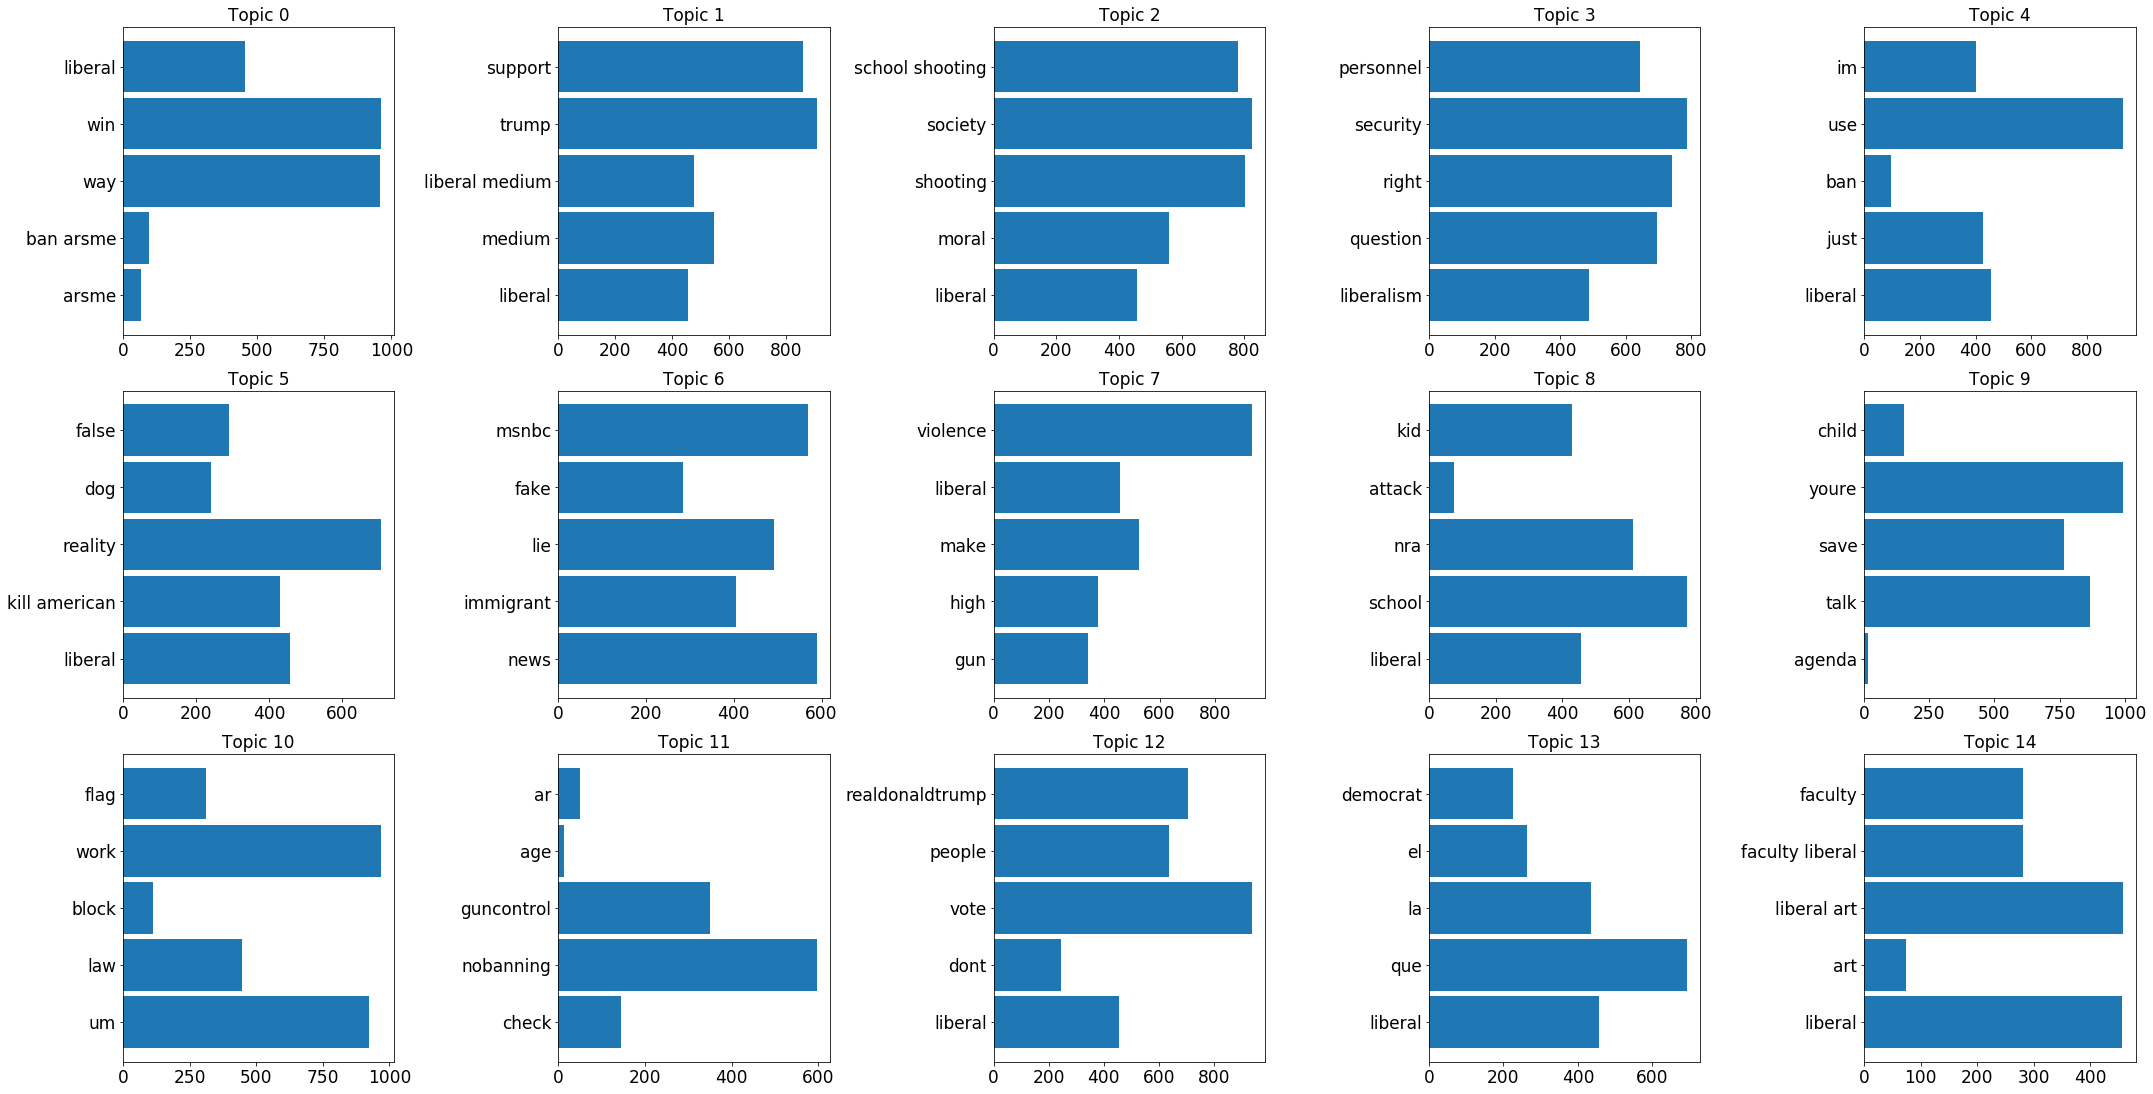

Drop tweets 

Dimensions before (3600, 8)
Dimensions after (1692, 8)
Dimensionality reduction...
Done
RangeIndex(start=0, stop=1692, step=1)
Most representative tweet of topic 0:
 Thank you @RandPaul for bringing attention to the liberal hypocrisy. https://t.co/fOMkMeKXkx 

Most representative tweet of topic 1:
 @bbusa617 @ananavarro @CNN @ABC @NBCNews @CBS The lying liberal media must share responsibility for the crimes and violence of gangs like MS-13. Support &amp; defense of these animals equals complicity. Liberal media are shameful and have no decency. #FakeNews 

Most representative tweet of topic 2:
 Years ago, school shootings were unheard of. What changed? The liberal influence on society and education. It requires a moral compass to handle stressful situations maturely. The liberal base lacks that quality so they respond in the manner of a petulant brat. | #RedNationRising 

Most representative tweet of topic 3:
 Right on @RedNationRising.
The Question is What Has Changed?
A

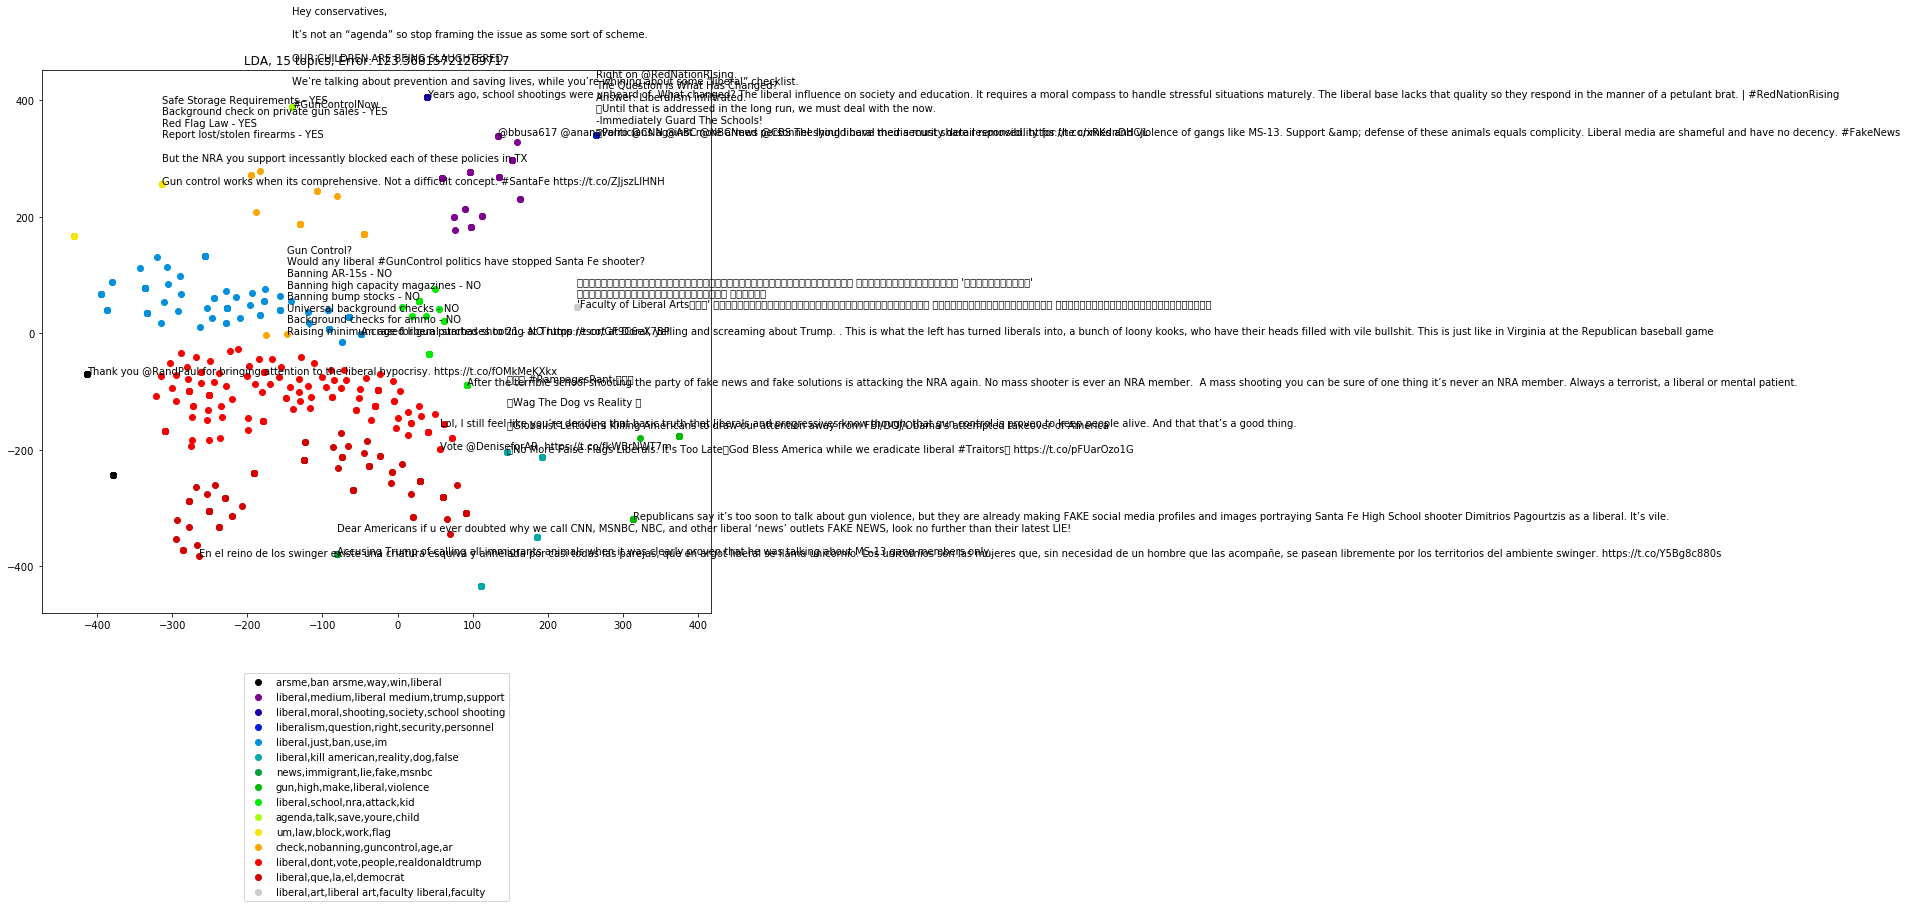

In [14]:
#tweet_dataframe, topics = nmf_analysis(tweet_dataframe, optimize = False, n_topics = topics) 
tweet_dataframe, topics = lda_analysis(tweet_dataframe, stream_info = stream_info, optimize = False, n_topics = n_topics)      
#tweet_dataframe, topics = lda_analysis(tweet_dataframe, stream_info = tweet_stream)

Test what exactly is going on with the null data:

In [3]:
tweet_dataframe = pd.read_csv(
    "~/Documents/Git/Twitter-Mining/streaming_tweets/data/streaming_raid_reduced.tsv", sep = '\t')
    #"~/Documents/Git/Twitter-Mining/streaming_tweets/data/streaming_guns_rights_guncontrol_converted_tweets.tsv", sep = '\t')


In [4]:
import pandas as pd
import numpy as np
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


def testing_df(data, text):
    cnt = 0
    a = np.where(data.isnull())
   
    #print("bad spot:", text.loc[a[0][0]])
def testing_tf(data):

    n_features = 1000 
    n_topics = 2
    n_top_words = 15

    tf_vectorizer = CountVectorizer(max_df = 0.95, min_df = 2, max_features = n_features, stop_words='english')
    tf = tf_vectorizer.fit_transform(data)
    tf_feature_names = tf_vectorizer.get_feature_names()



print(tweet_dataframe.shape)
print(tweet_dataframe.isnull().sum())
tweet_dataframe = tweet_dataframe.dropna()
#testing_df(tweet_dataframe['filtered_text'], tweet_dataframe['text'])
#print(tweet_dataframe.isnull().sum())
#testing_tf(tweet_dataframe['filtered_text'])

(146619, 7)
Unnamed: 0       0
Unnamed: 0.1     0
date             0
likes            0
retweets         0
text             0
filtered_text    0
dtype: int64


Running the model using Pipeline. Pipeline is a good way to test the model quicky.

In [4]:
from sklearn.pipeline import Pipeline

In [5]:
tweet_dataframe = pd.read_csv(
    "~/Documents/Git/Twitter-Mining/streaming_tweets/data/streaming_guns_rights_guncontrol_converted_tweets.tsv", sep = '\t')
    #"~/Documents/Git/Twitter-Mining/streaming_tweets/data/streaming_liberal_converted_tweets.tsv", sep = '\t')

n_features = 1000 
n_topics = 10

cv = CountVectorizer(max_df = 0.95, min_df = 2, max_features = n_features, stop_words='english')
lda = LatentDirichletAllocation(n_components = n_topics, random_state=0)
pipe = Pipeline(steps=[('CountVectorizer', cv), ('LatentDirichletAllocation ', lda)])

probabilities = pipe.fit_transform(tweet_dataframe['filtered_text'])
pipe.score(tweet_dataframe['filtered_text'])

/home/timor/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:532: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


-23090.006518368904

Histograms of probability of a document being in a topic.

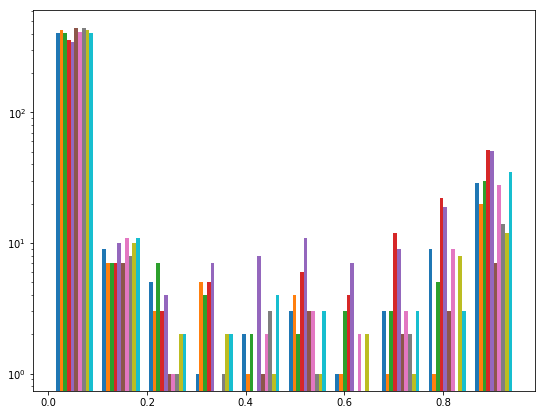

In [6]:
plt.figure(figsize=(9,7))
plt.hist(probabilities)
plt.yscale('log')

plt.savefig(
        '/home/timor/Documents/Git/Twitter-Mining/streaming_tweets/data/liberal/{0}_tweetP_topic_{1}.png'.format(stream_info, n_topics),
        bbox_inches='tight'            
        )

plt.show()
plt.close()

Test the tweet dropping function. This was annoying to set up

In [123]:
def drop_tweets_test(probabilities, tweet_dataframe):
    
    reduced_df = tweet_dataframe.copy()
    print("Drop tweets \n")
    probabilities_df = pd.DataFrame(probabilities).copy()
    #print(probabilities_df.head)
    probabilities_df.where(probabilities_df >.90, inplace = True)
    probabilities_df.dropna(how='all', inplace = True)
    #print("after reduction\n",probabilities_df.head)
    print(reduced_df.shape)
    reduced_df = reduced_df.loc[probabilities_df.index]
    print(reduced_df.shape)
    return(reduced_df, probabilities_df.index)

reduced_data, reduced_index = drop_tweets_test(probabilities, tweet_dataframe)
#print(reduced_data.index)
p_test = pd.DataFrame(probabilities).copy()
#print(p_test.head)
test = p_test.loc[reduced_index]
p = probabilities[reduced_index]
print(p[:10])
print(test[:10])
#print(reduced_index)
#print(probabilities.shape)
#print(test.head)


Drop tweets 

(471, 22)
(189, 22)
[[ 0.00625008  0.00625     0.94374849  0.00625     0.00625     0.00625
   0.00625014  0.00625029  0.00625     0.006251  ]
 [ 0.00769231  0.00769231  0.00769234  0.00769231  0.00769231  0.00769238
   0.93076913  0.00769231  0.00769231  0.00769231]
 [ 0.00666674  0.00666676  0.00666676  0.00666674  0.00666685  0.00666667
   0.00666675  0.00666667  0.9399994   0.00666667]
 [ 0.00666667  0.00666668  0.00666669  0.00666673  0.00666667  0.00666671
   0.00666668  0.00666667  0.00666667  0.93999985]
 [ 0.0083334   0.92499224  0.00833346  0.00833389  0.00833366  0.00833387
   0.00833355  0.00833333  0.00833344  0.00833916]
 [ 0.00909091  0.00909093  0.00909107  0.00909098  0.9181812   0.00909091
   0.009091    0.00909091  0.00909115  0.00909095]
 [ 0.00769255  0.00769302  0.00769252  0.00769299  0.00769301  0.0076928
   0.9307621   0.00769231  0.00769263  0.00769607]
 [ 0.00666667  0.00666668  0.00666669  0.00666673  0.00666667  0.00666671
   0.00666668  0.0066

Testing the the function that selects tweets most representative of a topic. Run above pipeline first

In [47]:
import pickle
representative_tweets = {}
index = []
probabilities_df = pd.DataFrame(probabilities).copy()

for i in range(n_topics):
    index.append(probabilities_df.iloc[:, i].idxmax())
    print("Most representative tweet of topic {}:\n".format(i), tweet_dataframe.loc[index[i], 'text'], "\n")
    key = '{}'.format(i)
    representative_tweets[key] = tweet_dataframe.loc[i, 'text']
    index_top5 = np.argsort(probabilities_df.loc[:, i])[:-6:-1]
    #print(probabilities_df.loc[index_top5, i], "\n")
    #print("Top 5 most representative tweets:\n", tweet_dataframe.loc[index_top5, 'text'], "\n")

with open('representative_tweets.pickle', 'wb') as f:
    pickle.dump(representative_tweets, f)

Most representative tweet of topic 0:
 RT @Brink_Token: Send 0.5 - 1 ETH get exclusive rights to Brink Inc + 20 Million BRTK + 10 Million of our next tokens and full refund 
+ Bo… 



KeyError: 'the label [label] is not in the [index]'

In [45]:
with open('representative_tweets.pickle', 'rb') as f:
    representative_tweets = pickle.load(f)

print(representative_tweets)

{'0': 'RT @dianacoromines: Open letter from Danish MPs to Spanish govt: stop jailing democratically elected politicians &amp; grass-root leaders, resp…', '1': 'rt🔒I’ll be on zoloft till the day i die. Just like a type 1 diabetic will be on insulin for life. Suck my ovaries N… https://t.co/XrAMubzeEW', '2': 'Rights holders need to work with brands on digital activations for authenticity.  #IEG2018', '3': 'RT @CHN_AdamWodon: Right-wing talk show hosts attacking the teenage victims of Parkland for speaking out on guns, would be like attacking t…', '4': "#NowPlaying Jeremih - Cards Right (Clean) \n***WE DON'T OWN RIGHTS TO MUSIC PLAYED*** \n**Website/Instant Requests**… https://t.co/EtDxHhcN23", '5': 'RT @LilaGraceRose: As outrageous as it seems, @womensmarch support of sex trafficking website #Backpage shouldn’t surprise us. \n\nPlanned Pa…', '6': 'RT @SiphamandlaGoge: #ANCKZN Bodyguards allegedly belonging to some mayors and MEC(s) had guns drawn on party members at the ANC Moses Mabh…',

The below visualization functions run in two ways: 
One, if the grid search function is being used to explore the number of topics. In this case gridsearch will automatically call visualize_mpl and save plots.
And two, if the grid search function is not being used, the model first must be built from a single topic in the cell above. Once the topic model has been built, run either visualize_plotly or mpl to plot. If plotly is being used, the number of colors/topics must be hardcoded in the function.

To use the plotly function, the colors have to be set by hand.

In [13]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import plot

In [6]:
def visualize_plotly(dataframe, topics): 
    """
    Visualize tsne data using plotly. The colors and number of topics must be hardcoded.
    """

    # oh wow very annoying problem
    # https://stackoverflow.com/questions/25792086/panda-merge-return-empty-dataframe
    df_palette = pd.DataFrame([
            [0, '#C03028'],
            [1, '#F08030'],
            [2, '#6890F0'],
            [3, '#78C850'],
            [4, '#A890F0'],
            [5, '#A040A0'],
            [6, '#F8D030'],
            [7, '#E0C068'],
            [8, '#F85888'],
            [9, '#B8A038'],
            [10, '#98D8D8'],  
            [11, '#A8B820'],
            [12, '#7038F8'],
            [13, '#705898'],
            [14, '#705848']])
            #[15, '#B8B8D0'],
            #[16, '#A8A878'],
            #[17, '#EE99AC']])
            
    df_palette.columns = ['labels', 'typecolor']
    dataframe.merge(df_palette, on = 'labels')

    plot_list = []
    
    for idx, (label, color) in df_palette.iterrows():
   
        # Select data that corresponds to 1 topic
        df_filter = dataframe[dataframe['labels'] == label]

        # create a scatter object for each topic
        scatter = dict(
            mode = "markers",
            name = "{}".format(topics[label]), # returns label
            type = "scatter",
            text =  df_filter['text'],
            showlegend = True,
            #legendgroup = "stuff", # can use this to group things in the legend I think...
            x =  df_filter['x'], y =  df_filter['y'],
            marker = dict( 
                #size=10, 
                color = color)) 
                #line = dict(
                #width = 3)))
    
        plot_list.append(scatter) 
    
    # need this to override plotly non-iterative settings
    empty_axis = dict(zeroline=False, showaxeslabels=False, showticklabels=False, title='')
    layout = dict(
                scene = dict(
                    xaxis = empty_axis,
                    yaxis = empty_axis,
                    ),
                hovermode = 'closest',
                showlegend = True)

    fig = dict(data = plot_list, layout = layout)
    plot_url = py.plot(fig)
    
    
def visualize_mpl(dataframe, topics, error = None, method = None):
    """
    Plot tsne data using matplotlib. When calling this function, no error or method need be
    provided. These arguments are only used by gridsearch.
    """
    
    with open('representative_tweets.pickle', 'rb') as f:
        representative_tweets = pickle.load(f)
          
    with open('rep_tweet_index.pickle', 'rb') as f:
        index = pickle.load(f)
    
    colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(set(pd.Series(dataframe['labels'])))))
    # https://matplotlib.org/examples/color/colormaps_reference.html

    fig, ax = plt.subplots(figsize = (15, 10))
    
    if error == None:
        ax.set_title('{0} topics'.format(len(topics)))
    else:
        ax.set_title('{0}, {1} topics, Error: {2}'.format(method, len(topics), error))

    # Thank you!:
    #https://stackoverflow.com/questions/46819664/how-to-add-labels-to-t-sne-in-python
    # https://www.kaggle.com/tilii7/t-sne-visualization/code

    for i, color in zip(range(len(topics)), colors):
        ax.scatter(dataframe.loc[dataframe['labels'] == i, 'x'],
                   dataframe.loc[dataframe['labels'] == i, 'y'], 
                   label = topics[i], c = color)
        
        ax.annotate(representative_tweets['{}'.format(i)],
            xy = (dataframe.loc[index[i], 'x'], dataframe.loc[index[i], 'y'])             
            #xy = (dataframe.loc[i, 'x'], dataframe.loc[i, 'y'])
        )
  
    # https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    # Put a legend to the right of the current axis
    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.legend(loc=9, bbox_to_anchor=(.5, -.1))
    
    #for i, j in representative_tweets.iteritems():
        

    plt.show()
    
    #if method != None: # method only != none when gridsearch runs
    #    fig.savefig('/home/timor/Documents/Git/Twitter-Mining/streaming_tweets/data/{0}_topics_{1}.png'.format(len(topics), method))
    
    #fig.savefig('/home/timor/Documents/Git/Twitter-Mining/streaming_tweets/data/topic_model_tsnedrop2.png'.format(len(topics), method))
    
    plt.close()

If model has been generated, and tsne and label columns have been added, run just the visualization functions below to see the clusters

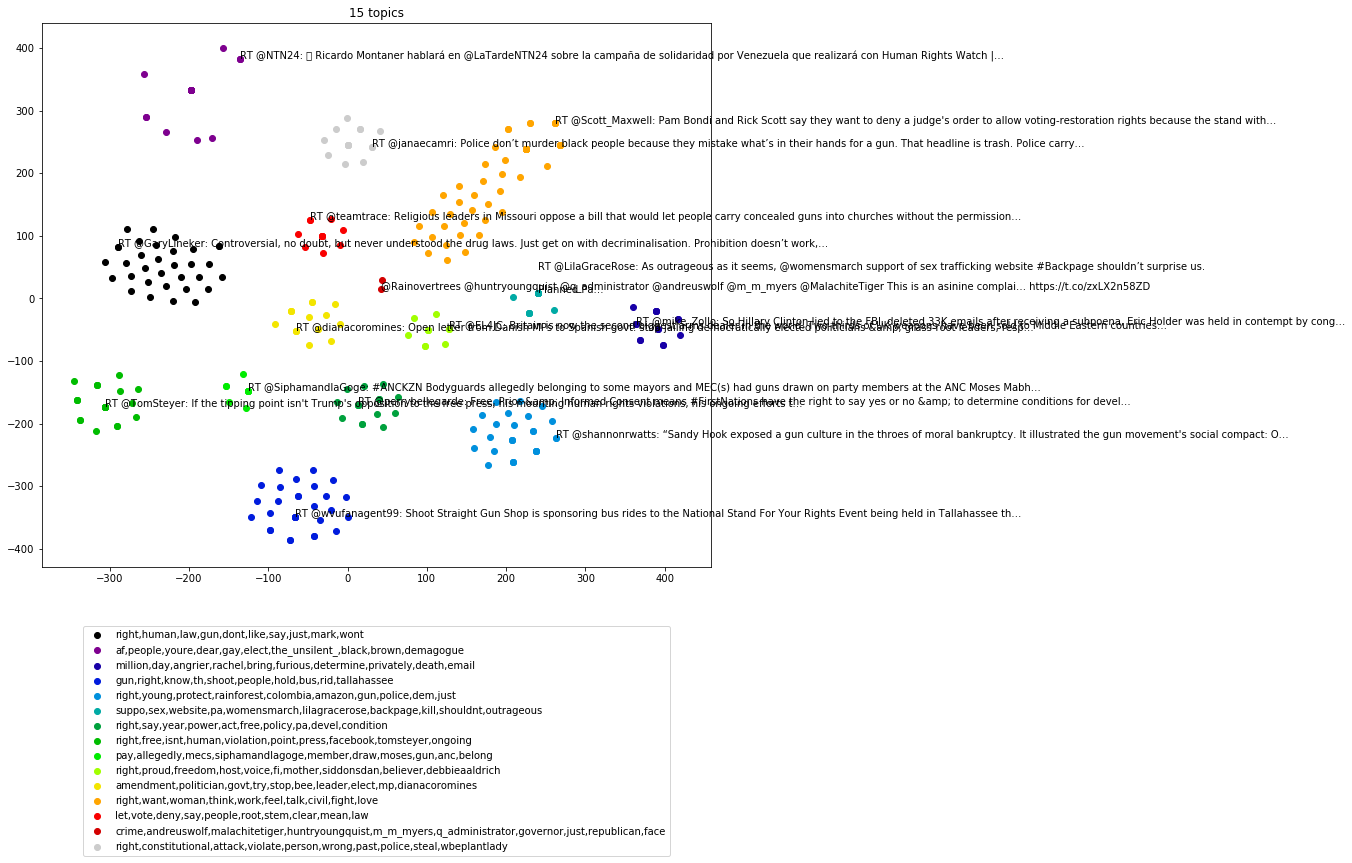

In [54]:
#visualize_plotly(tweet_dataframe, topics)
visualize_mpl(tweet_dataframe, topics)